## Neural networks for segmentation

In [0]:
! wget -q https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

In [0]:
#! wget -q "https://drive.google.com/uc?export=download&id=1VGI-SZSEZu5kmhwwxFCxyAGyupipiH2W" -O rcParams_dict.npy

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
#!pip install -q imageio

In [0]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
# rcParams_dict = np.load('rcParams_dict.npy').item()
# for key in plt.rcParams.keys():
#     if key != 'datapath':
#         plt.rcParams[key] = rcParams_dict[key]

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
# http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### Препроцессинг картинок

In [0]:
# !pip install -q Pillow==4.0.0

Загрузим изображения. Сразу заметим, что в изображениях клеток содержательным является только зелёный канал, поэтому работать будем только с ним.

In [0]:
from PIL import Image
import os

train_images_path = 'BBBC018_v1_images-fixed/train/'
train_outlines_path = 'BBBC018_v1_outlines/train/'
val_images_path = 'BBBC018_v1_images-fixed/val/'
val_outlines_path = 'BBBC018_v1_outlines/val/'
test_images_path = 'BBBC018_v1_images-fixed/test/'

train_images =   [Image.fromarray(np.array(Image.open(os.path.join(train_images_path, fname)))[:, :, 1])
                  for fname in sorted(os.listdir(train_images_path))]
train_outlines = [Image.fromarray(np.array(imread(os.path.join(train_outlines_path, fname)), dtype='uint8'))
                  for fname in sorted(os.listdir(train_outlines_path))]
val_images =     [Image.fromarray(np.array(Image.open(os.path.join(val_images_path, fname)))[:, :, 1])
                  for fname in sorted(os.listdir(val_images_path))]
val_outlines =   [Image.fromarray(np.array(imread(os.path.join(val_outlines_path, fname)), dtype='uint8'))
                  for fname in sorted(os.listdir(val_outlines_path))]
test_images =    [Image.fromarray(np.array(Image.open(os.path.join(test_images_path, fname)))[:, :, 1])
                  for fname in sorted(os.listdir(test_images_path))]

В качестве аугментации будем использовать случайное отражение по вертикали/горизонтали, случайный поворот на небольшой угол с последующим обрезанием и ресайзом (чтобы не оставалось черных углов после поворота) и случайное изменение яркости и контрастности. Заметим, что здесь возникают трудности со стандартными функциями, так как нам нужно применить случайное преобразование не только ко входному изображению, но и к изображению с правильной разметкой.

In [0]:
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class CellOutlinesDataset(Dataset):
    def __init__(self, images, outlines, transform=None):
        self.data = list(zip(images, outlines))
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.transform:       
            return self.transform(self.data[idx])
        
        return self.data[idx]

def random_hflip(x):
    if random.random() < 0.5:
        return x
    return (x[0].transpose(Image.FLIP_LEFT_RIGHT),
            x[1].transpose(Image.FLIP_LEFT_RIGHT))

def random_vflip(x):
    if random.random() < 0.5:
        return x
    return (x[0].transpose(Image.FLIP_TOP_BOTTOM),
            x[1].transpose(Image.FLIP_TOP_BOTTOM))

def random_rotation(x):
    img, outline = x
    h, w = img.size
    degree = random.randint(-15, 15)
    rad = abs(degree / 180 * np.pi)
    k = np.sin(rad) / np.sin(np.pi / 4 + rad) * (1 - np.tan(rad / 2)) / 2 ** 0.5
    k /= 2
    
    img = img.rotate(degree).crop((k * w, k * h, (1-k) * w, (1-k) * h)).resize((h, w))
    outline = outline.rotate(degree).crop((k * w, k * h, (1-k) * w, (1-k) * h)).resize((h, w))
    
    return (img, outline)

def color_jitter(x):
    t = transforms.ColorJitter(brightness=0.6, contrast=0.6)
    
    return (t(x[0]), x[1])

def to_tensor(x):
    t = transforms.ToTensor()
    
    return (t(x[0]), t(x[1]).type(torch.LongTensor))
    
    
    
transform_train = transforms.Compose([
    color_jitter,
    random_hflip,
    random_vflip,
    random_rotation,
    to_tensor,
])

trainset = CellOutlinesDataset(train_images, train_outlines, transform_train)

Наша сеть будет возвращать картинку такого же размера, как и входное изображение. В качестве функции потерь будем использовать кроссэнтропию с весами, чтобы побороть неравномерность в количестве представителей классов. Обучать модель будем Адамом с остановкой по качеству на валидации. Для получения финального контура будем сравнивать предсказания сети с порогом в 0.75 (который был подобран экспериментально).

In [0]:
from IPython.display import clear_output
import time
from copy import deepcopy

def compute_loss(net, X_batch, y_batch):
    X_batch = Variable(X_batch).cuda()
    y_batch = Variable(y_batch).cuda()
    
    logits = net(X_batch)
    logits = logits.permute(0, 2, 3, 1).contiguous().view(-1, 2)
    y_batch = y_batch.view(-1)
    weight = Variable(torch.FloatTensor([1, 10])).cuda()
    
    return F.cross_entropy(logits, y_batch, weight=weight)

def train_model(model, trainset, valset, training_params=None,
                threshold=0.75, timer_limit=14):
    training_params = training_params or {
                                           'num_epochs': 10,
                                           'batch_size': 1,
                                           'initial_lr': 0.001,
                                           'lr_decay_factor': 2,
                                           'lr_decay_stride': 10
                                         }
    num_epochs = training_params['num_epochs']
    batch_size = training_params['batch_size']
    lr = training_params['initial_lr']
    lr_decay_factor = training_params['lr_decay_factor']
    lr_decay_stride = training_params['lr_decay_stride']
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             pin_memory=True, num_workers=1)

    train_loss_batches = []
    train_loss_epochs = []
    val_iou_epochs = []
    time_epochs = []
    
    best_iou = 0.
    best_model_state = None
    timer = 0
    
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lr_decay_stride,
                                                gamma=1 / lr_decay_factor)
    
    for epoch in range(num_epochs):
        scheduler.step()
        start_time = time.time()
        model.train()
        for data_batch in trainloader:
            X_batch, y_batch = data_batch
            loss = compute_loss(model, X_batch, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss_batches.append(loss.cpu().data.numpy()[0])
        train_loss_epochs.append(np.mean(train_loss_batches[-len(trainloader):]))
        
        model.eval()
        iou = calc_iou([get_mask(net, img, threshold) for img in val_images],
                       [np.array(out) for out in val_outlines])
        val_iou_epochs.append(iou)
        
        time_epochs.append(time.time() - start_time)   
        
        if val_iou_epochs[-1] > best_iou:
            best_iou = val_iou_epochs[-1]
            best_model_state = deepcopy(model.state_dict())
            timer = 0
        else:
            timer += 1  
                
        clear_output(True)
        plot_training_log((train_loss_epochs, val_iou_epochs), max(1, epoch - 29))

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_epochs[-1]))
        print("  training loss (in-iteration): \t{:.6f}".format(
            train_loss_epochs[-1]))
        print("  validation iou: \t\t\t{:.3f}".format(
            val_iou_epochs[-1]))
        print("  best validation iou: \t\t\t{:.3f}".format(best_iou))
        
        if timer > timer_limit:
            break
    
    model.load_state_dict(best_model_state)
    
    return train_loss_epochs, val_iou_epochs, time_epochs

def plot_training_log(log, start_epoch=1):
    epochs_num = len(log[0])
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    if len(log[1]):
        plt.title('Train loss and val iou')
    else:
        plt.title('Train loss')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(np.arange(start_epoch, epochs_num + 1), log[0][start_epoch-1:], c='b')
    
    if len(log[1]):
        ax2 = ax1.twinx()
        ax2.set_ylabel('Val iou', color='r')
        ax2.tick_params('y', colors='r')
        ax2.plot(np.arange(start_epoch, epochs_num + 1), log[1][start_epoch-1:], c='r')

    plt.show()

def get_mask(net, img, threshold=None):
    net.eval()
    logits = net(Variable(transforms.ToTensor()(img)[None]).cuda())
    probs = F.softmax(logits, dim=1)[0, 1, :, :].cpu().data.numpy()
    
    if threshold is not None:
        return probs > threshold
    
    return probs

def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

def iou_for_thresholds(net, imgs, outlines, min=0.7, max=0.79):
    thresholds = np.linspace(min, max, 10)
    results = []
    
    for threshold in thresholds:
        results.append(calc_iou([get_mask(net, img, threshold) for img in imgs],
                                [np.array(out) for out in outlines]))
    
    return {t: r for t, r in zip(thresholds, results)}

В качестве архитектуры будем использовать некоторое подобие U-net, где в середину вставим последовательность свёрток с дилейшенами, чтобы увеличивать поле восприятия финальных нейронов. В ходе экспериментов с глубинной (с точки зрения количества пулингов) было получено, что лучшие результаты даёт сеть с тремя пулингами. Также было замечено, что достаточно использовать слои с не очень большим числом каналов.

In [0]:
def one_layer(in_channels, out_channels):
    module = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                  kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    
    return module
    
def two_layer(in_channels, out_channels):
    module = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                  kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                  kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    
    return module

def dilation_seq(in_channels, out_channels, length):
    module = nn.Sequential()
    module.add_module('conv1', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=3, padding=1, bias=False))
    module.add_module('bn1', nn.BatchNorm2d(out_channels))
    module.add_module('relu1', nn.ReLU())
    
    for i in range(1, length + 1):
        module.add_module('conv' + str(i+1), nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                                                       kernel_size=3, dilation=2 ** i, padding=2 ** i, bias=False))
        module.add_module('bn' + str(i+1), nn.BatchNorm2d(out_channels))
        module.add_module('relu' + str(i+1), nn.ReLU())
    
    return module


class SegmentationNet1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = one_layer(1, 64)
        self.mp_1 = nn.MaxPool2d(kernel_size=2, padding=0)
        
        self.dilation = dilation_seq(64, 64, 7)
        
        self.upsample_1 = nn.Upsample(scale_factor=2)
        self.upconv_1 = one_layer(64 + 64, 64)

        self.logits = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1,
                                padding=0, bias=True)
        
    def forward(self, inp):
        inp_1 = self.conv_1(inp)
        inp_2 = self.dilation(self.mp_1(inp_1))
        inp_3 = self.upconv_1(torch.cat((inp_1, self.upsample_1(inp_2)), dim=1))
        
        return self.logits(inp_3)
    
    
class SegmentationNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = one_layer(1, 32)
        self.mp_1 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_2 = one_layer(32, 64)
        self.mp_2 = nn.MaxPool2d(kernel_size=2, padding=0)
        
        self.dilation = dilation_seq(64, 128, 6)
        
        self.upsample_1 = nn.Upsample(scale_factor=2)
        self.upconv_1 = one_layer(128 + 64, 64)
        self.upsample_2 = nn.Upsample(scale_factor=2)
        self.upconv_2 = one_layer(64 + 32, 32)

        self.logits = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1,
                                padding=0, bias=True)
        
    def forward(self, inp):
        inp_1 = self.conv_1(inp)
        inp_2 = self.conv_2(self.mp_1(inp_1))
        inp_3 = self.dilation(self.mp_2(inp_2))
        inp_4 = self.upconv_1(torch.cat((inp_2, self.upsample_1(inp_3)), dim=1))
        inp_5 = self.upconv_2(torch.cat((inp_1, self.upsample_2(inp_4)), dim=1))
        
        return self.logits(inp_5)
    
    
class SegmentationNet3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = two_layer(1, 16)
        self.mp_1 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_2 = two_layer(16, 32)
        self.mp_2 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_3 = two_layer(32, 64)
        self.mp_3 = nn.MaxPool2d(kernel_size=2, padding=0)
        
        self.dilation = dilation_seq(64, 128, 5)
        
        self.upsample_1 = nn.Upsample(scale_factor=2)
        self.upconv_1 = two_layer(128 + 64, 64)
        self.upsample_2 = nn.Upsample(scale_factor=2)
        self.upconv_2 = two_layer(64 + 32, 32)
        self.upsample_3 = nn.Upsample(scale_factor=2)
        self.upconv_3 = two_layer(32 + 16, 16)

        self.logits = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1,
                                padding=0, bias=True)
        
    def forward(self, inp):
        inp_1 = self.conv_1(inp)
        inp_2 = self.conv_2(self.mp_1(inp_1))
        inp_3 = self.conv_3(self.mp_2(inp_2))
        inp_4 = self.dilation(self.mp_3(inp_3))
        inp_5 = self.upconv_1(torch.cat((inp_3, self.upsample_1(inp_4)), dim=1))
        inp_6 = self.upconv_2(torch.cat((inp_2, self.upsample_2(inp_5)), dim=1))
        inp_7 = self.upconv_3(torch.cat((inp_1, self.upsample_3(inp_6)), dim=1))
        
        return self.logits(inp_7)


class SegmentationNet4(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = two_layer(1, 16)
        self.mp_1 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_2 = two_layer(16, 32)
        self.mp_2 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_3 = two_layer(32, 64)
        self.mp_3 = nn.MaxPool2d(kernel_size=2, padding=0)
        self.conv_4 = two_layer(64, 128)
        self.mp_4 = nn.MaxPool2d(kernel_size=2, padding=0)
        
        self.dilation = dilation_seq(128, 256, 4)
        
        self.upsample_1 = nn.Upsample(scale_factor=2)
        self.upconv_1 = two_layer(128 + 256, 128)
        self.upsample_2 = nn.Upsample(scale_factor=2)
        self.upconv_2 = two_layer(64 + 128, 64)
        self.upsample_3 = nn.Upsample(scale_factor=2)
        self.upconv_3 = two_layer(32 + 64, 32)
        self.upsample_4 = nn.Upsample(scale_factor=2)
        self.upconv_4 = two_layer(16 + 32, 16)

        self.logits = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1,
                                padding=0, bias=True)
        
    def forward(self, inp):
        inp_1 = self.conv_1(inp)
        inp_2 = self.conv_2(self.mp_1(inp_1))
        inp_3 = self.conv_3(self.mp_2(inp_2))
        inp_4 = self.conv_4(self.mp_3(inp_3))
        inp_5 = self.dilation(self.mp_4(inp_4))
        inp_6 = self.upconv_1(torch.cat((inp_4, self.upsample_1(inp_5)), dim=1))
        inp_7 = self.upconv_2(torch.cat((inp_3, self.upsample_2(inp_6)), dim=1))
        inp_8 = self.upconv_3(torch.cat((inp_2, self.upsample_3(inp_7)), dim=1))
        inp_9 = self.upconv_4(torch.cat((inp_1, self.upsample_3(inp_8)), dim=1))
        
        return self.logits(inp_9)

Обучим финальный вариант сети.

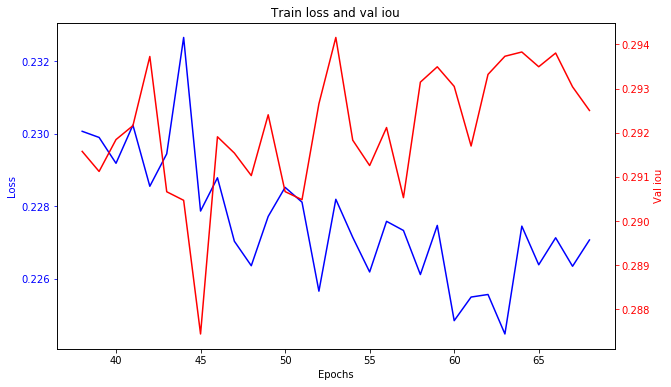

Epoch 68 of 100 took 7.897s
  training loss (in-iteration): 	0.227071
  validation iou: 			0.293
  best validation iou: 			0.294


In [65]:
net = SegmentationNet3()
net.cuda()

training_params =  {
                     'num_epochs': 100,
                     'batch_size': 1,
                     'initial_lr': 0.001,
                     'lr_decay_factor': 10,
                     'lr_decay_stride': 30
                   } 

log = train_model(net, trainset, (val_images, val_outlines), training_params)

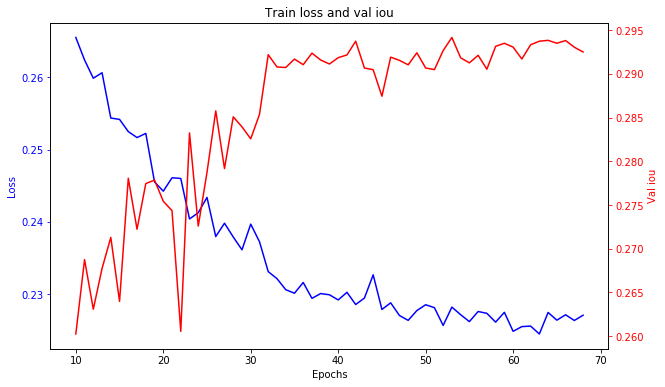

In [69]:
plot_training_log((log[0], log[1]), 10)

Посмотрим, как меняется качество при разных уровнях порога.

In [73]:
res = iou_for_thresholds(net, val_images, val_outlines)
res

{0.7: 0.28906904231625835,
 0.71: 0.29075031303175264,
 0.72: 0.2922980872921278,
 0.73: 0.29359756544336385,
 0.74: 0.2941042877906977,
 0.75: 0.2941584483720736,
 0.76: 0.2937550934496214,
 0.77: 0.29246699600881965,
 0.78: 0.2911500072327499,
 0.79: 0.2888204352212134}

In [74]:
res = iou_for_thresholds(net, train_images, train_outlines)
res

{0.7: 0.2907630904891023,
 0.71: 0.29274987350487985,
 0.72: 0.2944919144659059,
 0.73: 0.2958415964166407,
 0.74: 0.2970491243058522,
 0.75: 0.29767190546667605,
 0.76: 0.2978524279141941,
 0.77: 0.2974209437049817,
 0.78: 0.29641240977953587,
 0.79: 0.29456125997410315}

Порог в 0.75 действительно можно считать достаточно оптимальным.

In [0]:
def show_results(net, image, outline=None):
    mask = get_mask(net, image)
    
    if outline:
        iou = calc_iou(mask[None] > 0.75, np.array(outline)[None])
        print('iou = {:.3f}'.format(iou))

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.title('Image')
        plt.axis('off')
        plt.imshow(np.array(image), cmap='gray')
        plt.subplot(2, 2, 2)
        plt.title('True outline')
        plt.axis('off')
        plt.imshow(np.array(outline), cmap='gray')
        plt.subplot(2, 2, 3)
        plt.title('Predicted probs')
        plt.axis('off')
        plt.imshow(mask, cmap='gray')
        plt.subplot(2, 2, 4)
        plt.title('Predicted outline')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.imshow(mask > 0.75, cmap='gray')
    else:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.axis('off')
        plt.imshow(np.array(image), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('Predicted outline')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.imshow(mask > 0.75, cmap='gray')

Посмотрим на некоторые предсказания сети.

iou = 0.256


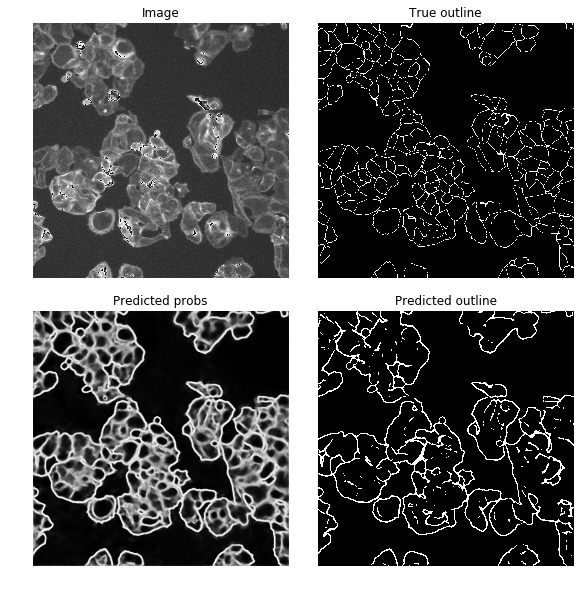

In [113]:
idx = np.random.choice(len(train_images))
show_results(net, train_images[idx], train_outlines[idx])

iou = 0.414


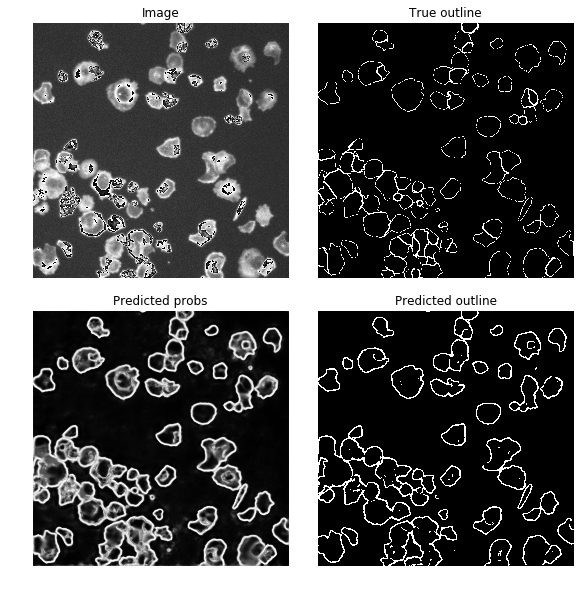

In [114]:
idx = np.random.choice(len(train_images))
show_results(net, train_images[idx], train_outlines[idx])

iou = 0.264


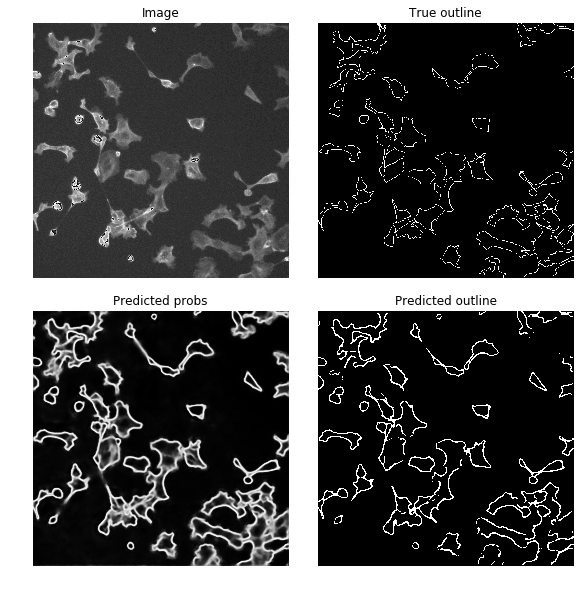

In [115]:
idx = np.random.choice(len(train_images))
show_results(net, train_images[idx], train_outlines[idx])

Хуже всего сеть работает на следующих двух картинках. Это неудивительно, потому что на них большое число клеток образует одну большую массу, выделить отельные клетки которой трудно даже человеку.

iou = 0.191


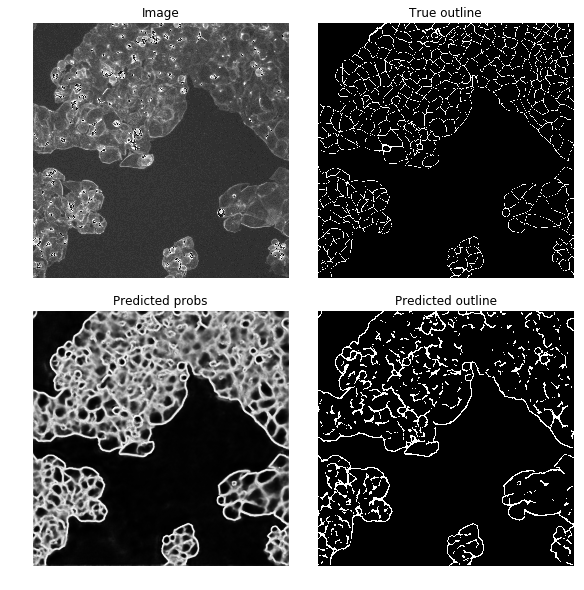

In [116]:
idx = -8
show_results(net, train_images[idx], train_outlines[idx])

iou = 0.201


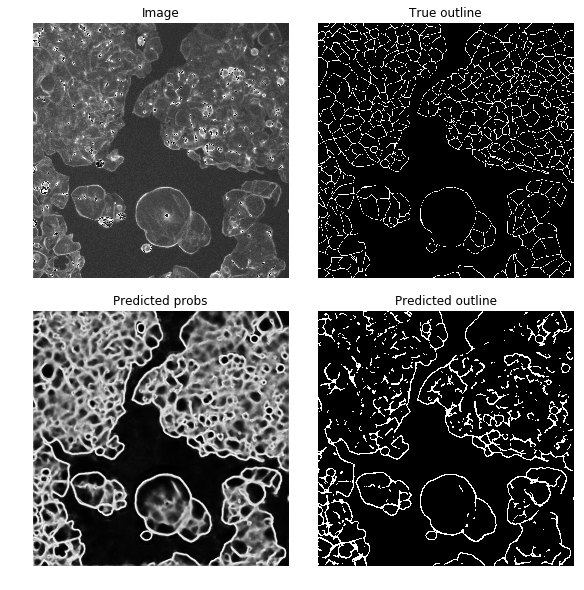

In [117]:
idx = -7
show_results(net, train_images[idx], train_outlines[idx])

Запустим сеть на тестовых картинках и посмотрим на результаты.

In [0]:
test_outlines = [get_mask(net, img, 0.75) for img in test_images]

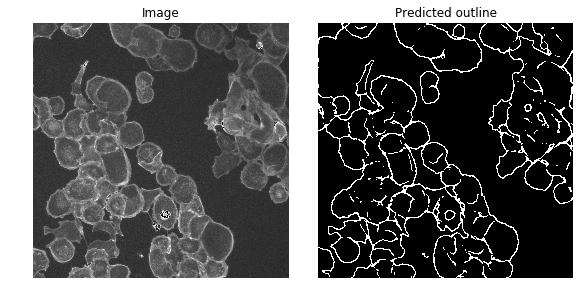

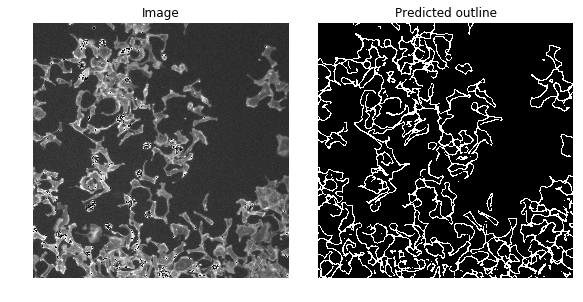

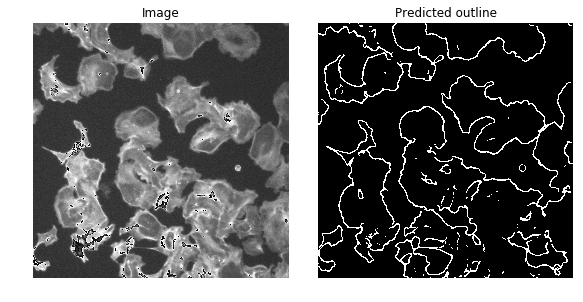

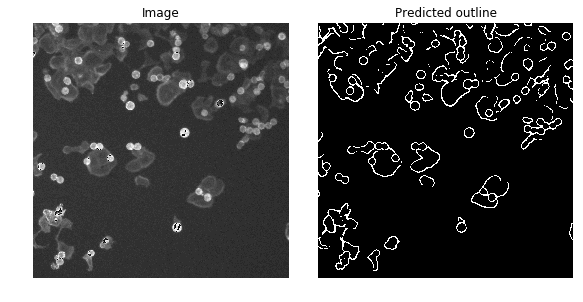

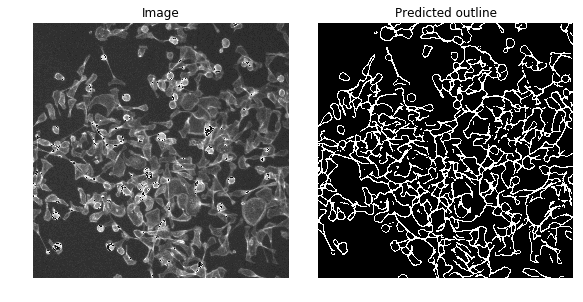

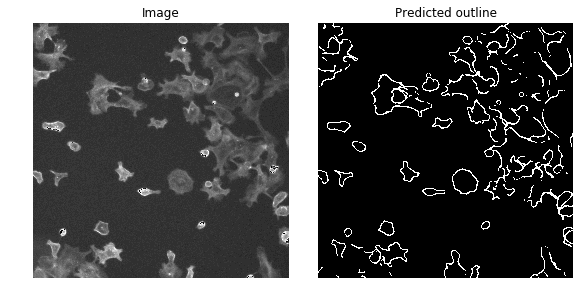

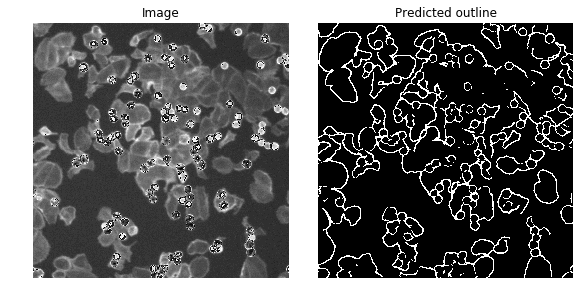

In [121]:
for img in test_images:
    show_results(net, img)

Запишем результаты для отправки.

In [0]:
from imageio import imwrite

test_names = [fname[:-4] + '.png' for fname in sorted(os.listdir(test_images_path))]

for name, img in zip(test_names, test_outlines):
    imwrite(name, img.astype('uint8') * 255)